<a href="https://colab.research.google.com/github/Heba2424/Teeth_Classification/blob/main/teeth_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA & Visualization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import glob
from tensorflow import keras
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping ,ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy

2024-08-21 14:39:00.009335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 14:39:00.009459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 14:39:00.151710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
path  = "/kaggle/input/teeth-dataset/Teeth DataSet/Teeth_Dataset"

In [ ]:
image_list = os.listdir(path)
image_list

['Validation', 'Training', 'Testing']

In [ ]:
image_filenames = glob.glob(os.path.join(path,'**/*.jpg'), recursive=True)

# create an info dataframe
df = pd.DataFrame({'filename': image_filenames})
df['partition'] = df['filename'].apply(lambda x: x.split(os.sep)[-3])
df['label'] = df['filename'].apply(lambda x: x.split(os.sep)[-2])

df

filename   partition label
0     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC
1     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC
2     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC
3     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC
4     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC
...                                                 ...         ...   ...
5138  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP
5139  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP
5140  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP
5141  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP
5142  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP

[5143 rows x 3 columns]

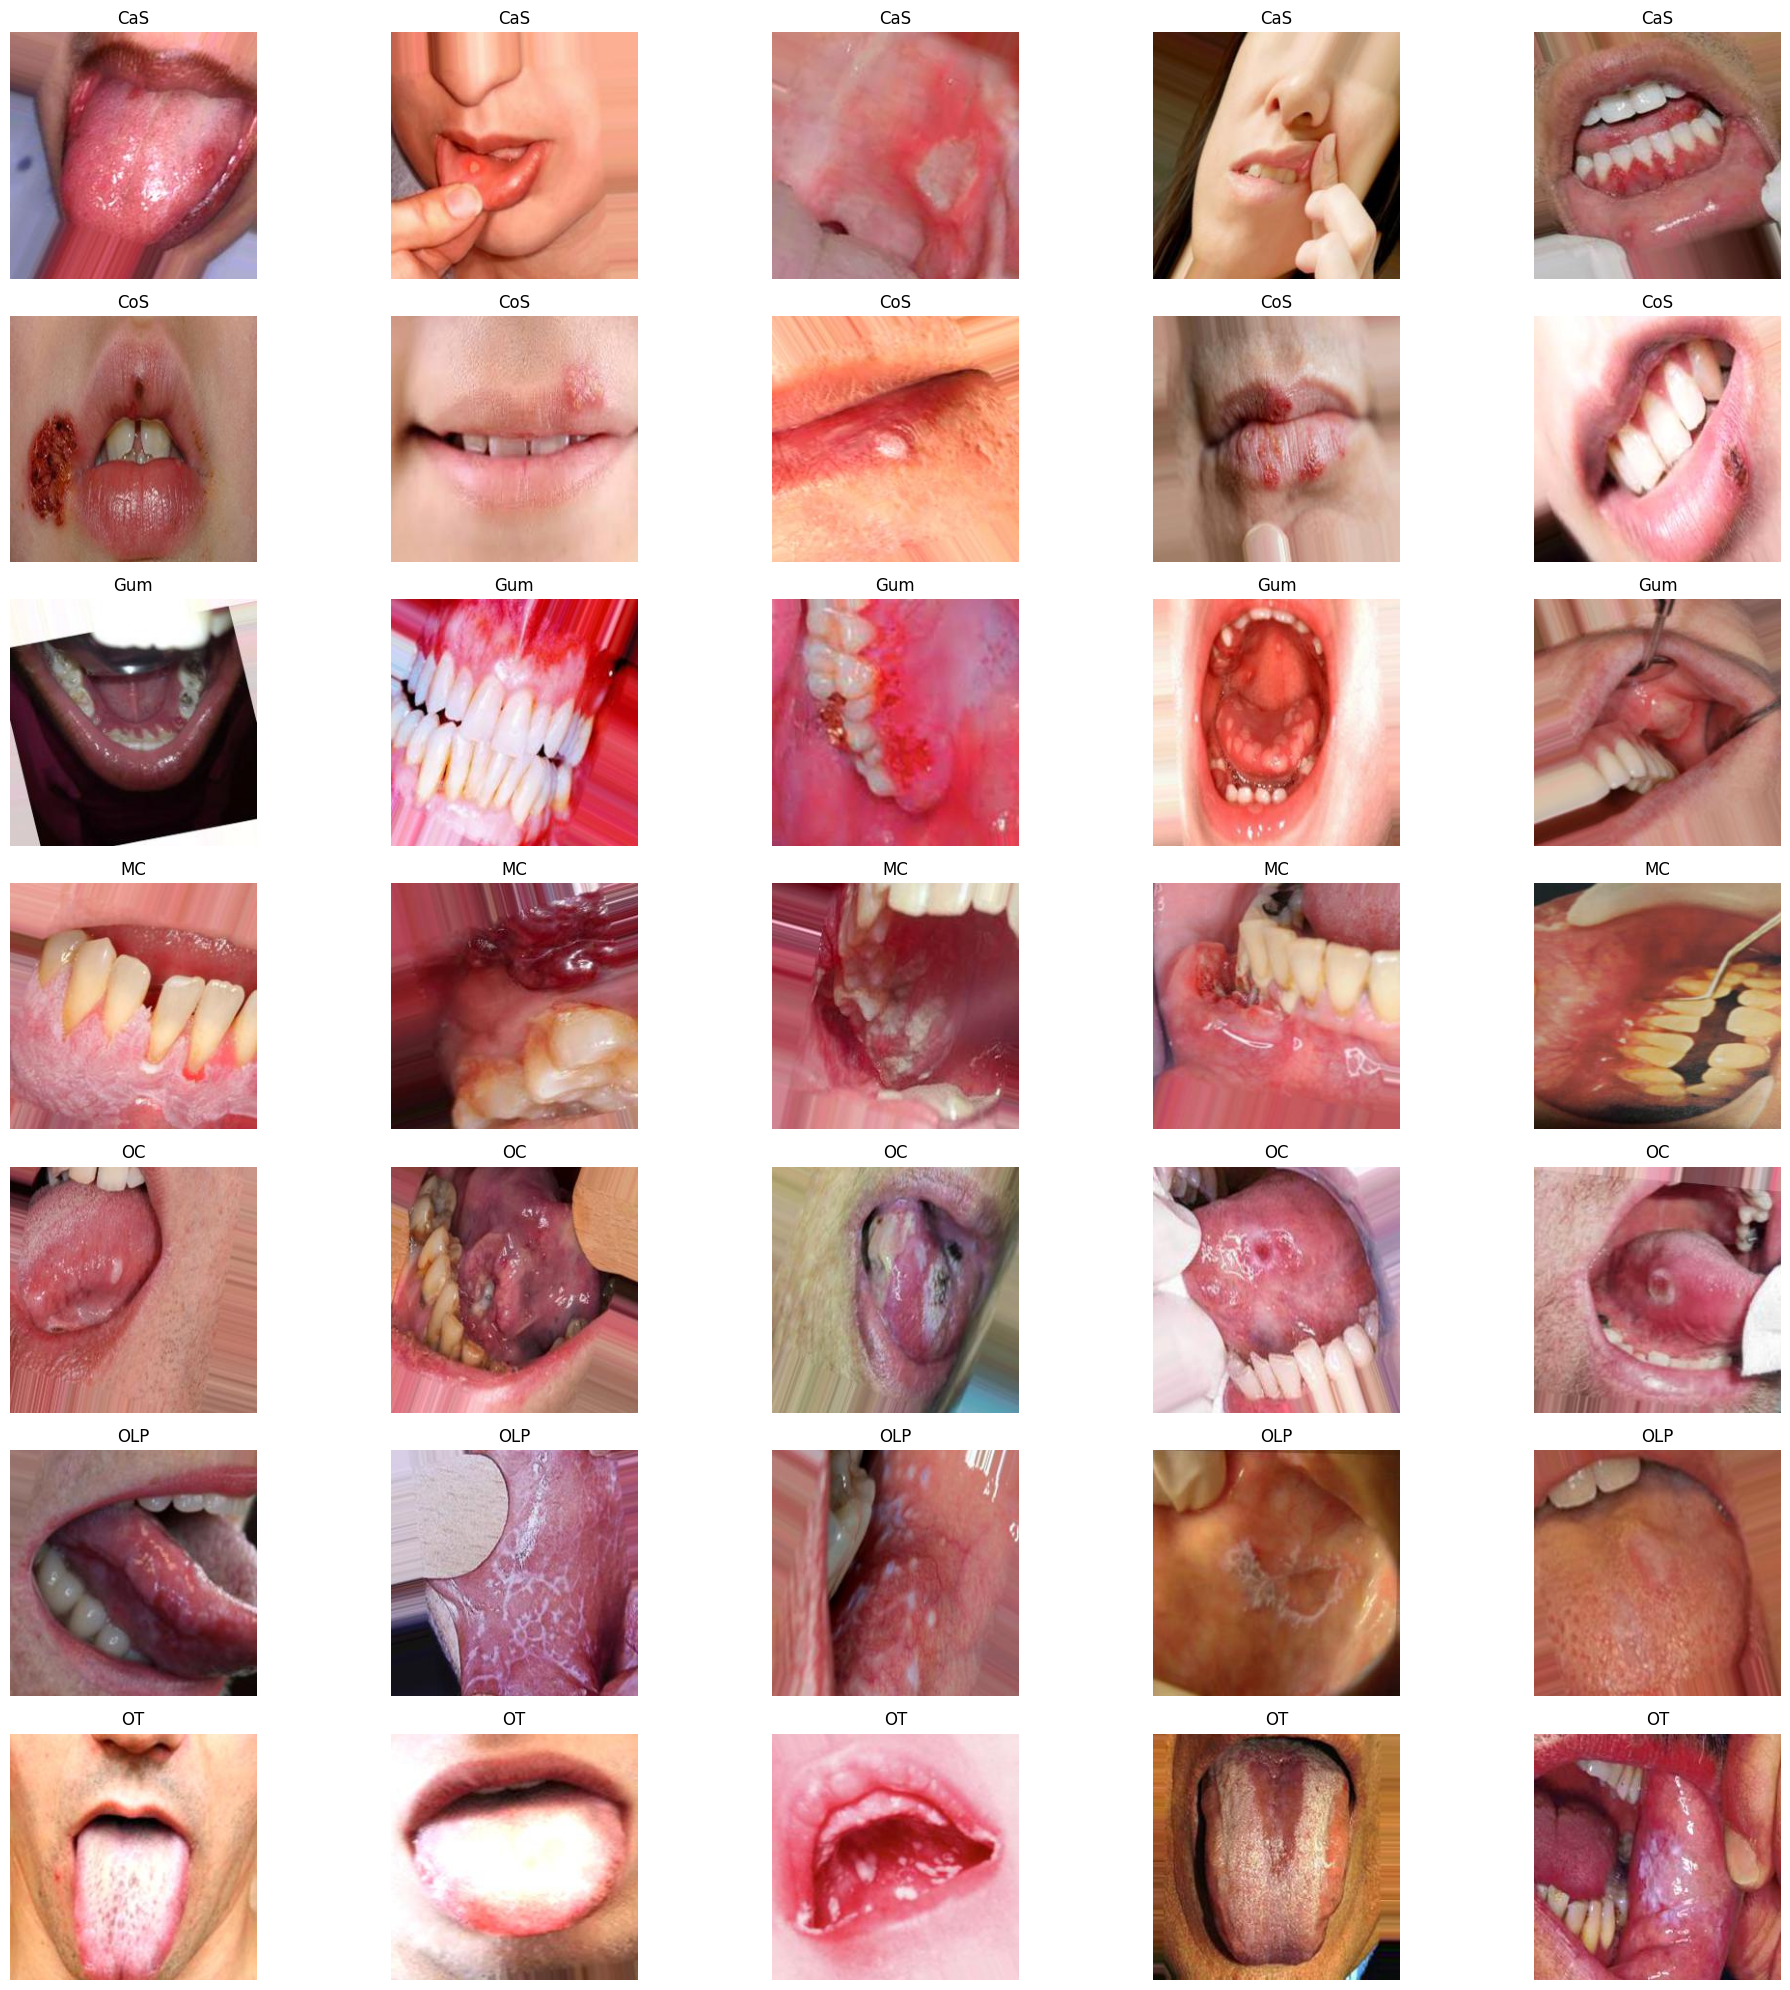

In [ ]:
fig, axs = plt.subplots(7, 5, figsize=(20, 20))

# List of labels corresponding to each title
labels = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]

# Loop through each label and plot images
for idx, label in enumerate(labels):
    for i in range(5):
        axs.flat[i + 5 * idx].imshow(plt.imread(df.query(f'label == "{label}"')['filename'].iloc[i]))
        axs.flat[i + 5 * idx].set_title(label)
        axs.flat[i + 5 * idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
df['label'].value_counts(ascending=True)

label
OC     540
Gum    600
OT     655
CoS    748
CaS    800
MC     900
OLP    900
Name: count, dtype: int64

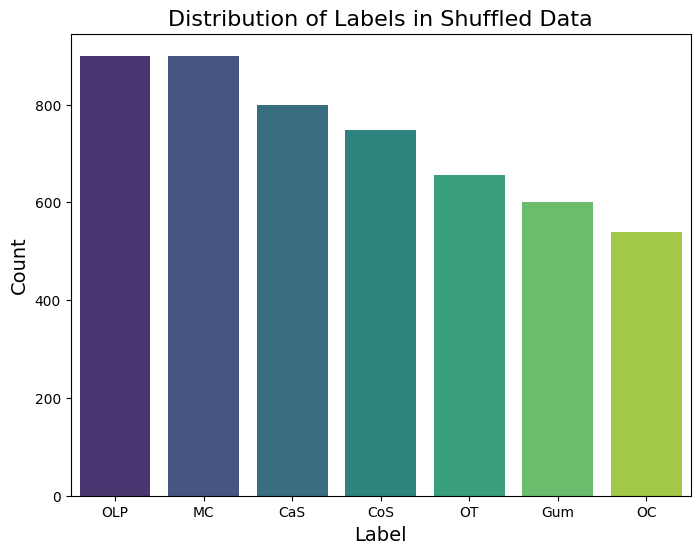

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences of each target label
label_counts = df['label'].value_counts()

# Plot the label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

# Add title and labels
plt.title('Distribution of Labels in Shuffled Data', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the plot
plt.show()


## Preprocessing

### resize and scale images

In [ ]:
# resize images and normalization

def load_and_scale_image(image_path, target_size=(128, 128)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure image is in RGB format
        img = img.resize(target_size)  # Resize image to target size
        img_array = np.array(img)  # Convert to numpy array
        img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array


In [ ]:
# apply load_and_scale_image function to df
df['scaled_image'] = df['filename'].apply(lambda x: load_and_scale_image(x, target_size=(128, 128)))


In [ ]:
df['scaled_image']


0       [[[0.615686274509804, 0.3176470588235294, 0.32...
1       [[[0.5843137254901961, 0.27450980392156865, 0....
2       [[[0.7490196078431373, 0.6666666666666666, 0.4...
3       [[[0.7686274509803922, 0.6078431372549019, 0.6...
4       [[[0.8431372549019608, 0.7176470588235294, 0.6...
                              ...                        
5138    [[[0.10196078431372549, 0.21568627450980393, 0...
5139    [[[0.9607843137254902, 0.8980392156862745, 0.9...
5140    [[[0.6039215686274509, 0.3137254901960784, 0.3...
5141    [[[0.6196078431372549, 0.3607843137254902, 0.2...
5142    [[[0.6235294117647059, 0.44313725490196076, 0....
Name: scaled_image, Length: 5143, dtype: object

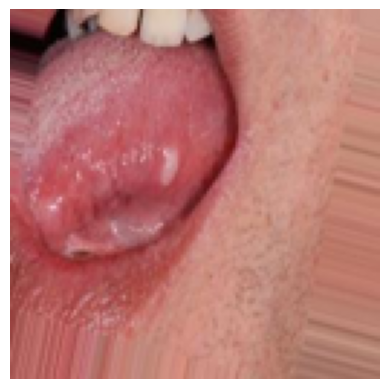

In [ ]:
# Select the first scaled image
scaled_image = df['scaled_image'].iloc[0]

# Display the image
plt.imshow(scaled_image)
plt.axis('off')  # Hide axes
plt.show()


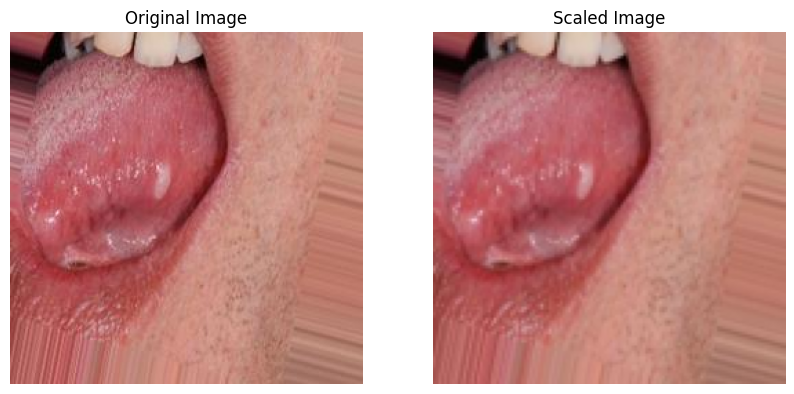

In [ ]:
# Import Matplotlib
import matplotlib.pyplot as plt

# Select the first original and scaled images
original_image_path = df['filename'].iloc[0]
scaled_image = df['scaled_image'].iloc[0]

# Load the original image using PIL
original_image = Image.open(original_image_path)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axes

# Display the scaled image
axes[1].imshow(scaled_image)
axes[1].set_title('Scaled Image')
axes[1].axis('off')  # Hide axes

# Show the images
plt.show()


In [ ]:
df

filename   partition label  \
0     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC   
1     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC   
2     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC   
3     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC   
4     /kaggle/input/teeth-dataset/Teeth DataSet/Teet...  Validation    OC   
...                                                 ...         ...   ...   
5138  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP   
5139  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP   
5140  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP   
5141  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP   
5142  /kaggle/input/teeth-dataset/Teeth DataSet/Teet...     Testing   OLP   

                                           scaled_image  
0     [[[0.615686274509804, 0.3176470588235294, 0.32...  
1     [[[0.5843137254901961, 0.27450980392156865, 0....  
2     [[[0.7490196078431373, 0.6666666666666666, 0.4...  
3     [[[0.7686274509803922, 0.6078431372549019, 0.6...  
4     [[[0.8431372549019608, 0.7176470588235294, 0.6...  
...                                                 ...  
5138  [[[0.10196078431372549, 0.21568627450980393, 0...  
5139  [[[0.9607843137254902, 0.8980392156862745, 0.9...  
5140  [[[0.6039215686274509, 0.3137254901960784, 0.3...  
5141  [[[0.6196078431372549, 0.3607843137254902, 0.2...  
5142  [[[0.6235294117647059, 0.44313725490196076, 0....  

[5143 rows x 4 columns]

### split data to train, valid and test

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Extract scaled images and labels
X = np.array(df['scaled_image'].tolist())
y = np.array(df['label'])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Train, validation, and test split
train_mask = df['partition'] == 'Training'
valid_mask = df['partition'] == 'Validation'
test_mask = df['partition'] == 'Testing'

X_train, y_train = X[train_mask], y_categorical[train_mask]
X_valid, y_valid = X[valid_mask], y_categorical[valid_mask]
X_test, y_test = X[test_mask], y_categorical[test_mask]


In [ ]:
X_train.shape

(3087, 128, 128, 3)

In [ ]:
y_categorical

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

### Data Augmentation

In [ ]:
## Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
   rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


train_gen = image_generator.flow(X_train, y_train, batch_size=32 ,shuffle=True)
valid_gen = image_generator.flow(X_valid, y_valid, batch_size=32 ,shuffle=True)
test_gen = image_generator.flow(X_test, y_test, batch_size=32 ,shuffle=True)


### balance class weigts

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))


In [ ]:
class_weights

{0: 0.9183928571428571,
 1: 0.9822383498854087,
 2: 1.2245238095238096,
 3: 0.8163492063492064,
 4: 1.3605820105820106,
 5: 0.8163492063492064,
 6: 1.1217011995637949}

## Model Traning

### Model 1

In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(128, 128, 3)),

    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,103 (2.66 MB)

 Trainable params: 696,103 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
train_step=train_gen.n//train_gen.batch_size
test_step=test_gen.n//test_gen.batch_size
valid_step =valid_gen.n//valid_gen.batch_size

In [ ]:

# Early stopping and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)


history = model.fit(
    train_gen,
    epochs=200,
    validation_data=valid_gen,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights
)


Epoch 1/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 35s 253ms/step - accuracy: 0.1304 - loss: 2.0038 - val_accuracy: 0.1449 - val_loss: 1.9796
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.1446 - loss: 1.9813 - val_accuracy: 0.1440 - val_loss: 1.9689
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.1578 - loss: 1.9630 - val_accuracy: 0.2111 - val_loss: 1.9596
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.1783 - loss: 1.9475 - val_accuracy: 0.1965 - val_loss: 1.9433
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.1950 - loss: 1.9372 - val_accuracy: 0.1955 - val_loss: 1.9266
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.2033 - loss: 1.9127 - val_accuracy: 0.1984 - val_loss: 1.9011
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.2278 - loss: 1.8754 - val_accuracy: 0.2451 - val_loss: 1.8551
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.2243 - loss: 1.8757 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.6249 - loss: 1.1328
Test Accuracy: 0.6304


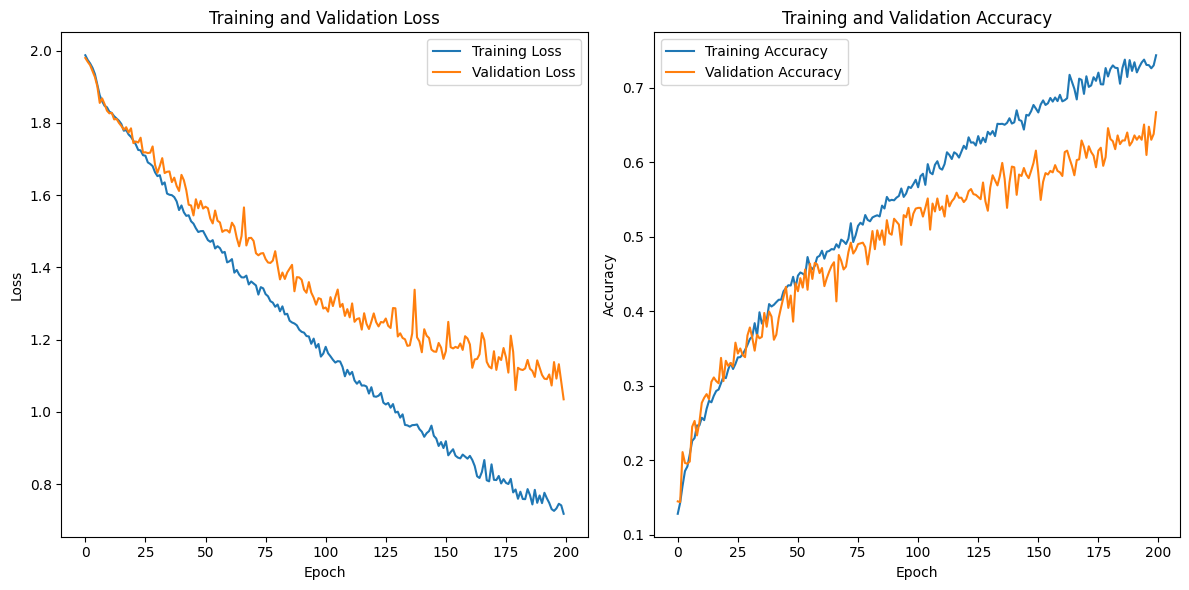

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


### Model 2

In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(128, 128, 3)),

    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,279,143 (4.88 MB)

 Trainable params: 1,279,143 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:

# Early stopping and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)


history = model.fit(
    train_gen,
    epochs=200,
    validation_data=valid_gen,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights
)


Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 295ms/step - accuracy: 0.1619 - loss: 2.0008 - val_accuracy: 0.1819 - val_loss: 1.9839
Epoch 2/200


W0000 00:00:1724097969.684542     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.1388 - loss: 1.9868 - val_accuracy: 0.1449 - val_loss: 1.9676
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - accuracy: 0.1644 - loss: 1.9611 - val_accuracy: 0.1449 - val_loss: 1.9576
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.1681 - loss: 1.9481 - val_accuracy: 0.1984 - val_loss: 1.9346
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.1994 - loss: 1.9209 - val_accuracy: 0.2461 - val_loss: 1.8487
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.2596 - loss: 1.8454 - val_accuracy: 0.2802 - val_loss: 1.8292
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.2566 - loss: 1.8327 - val_accuracy: 0.2578 - val_loss: 1.8204
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.2586 - loss: 1.8005 - val_accuracy: 0.2704 - val_loss: 1.8169
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.2622 - loss: 1.8190 - val_accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.6858 - loss: 1.0304
Test Accuracy: 0.6907


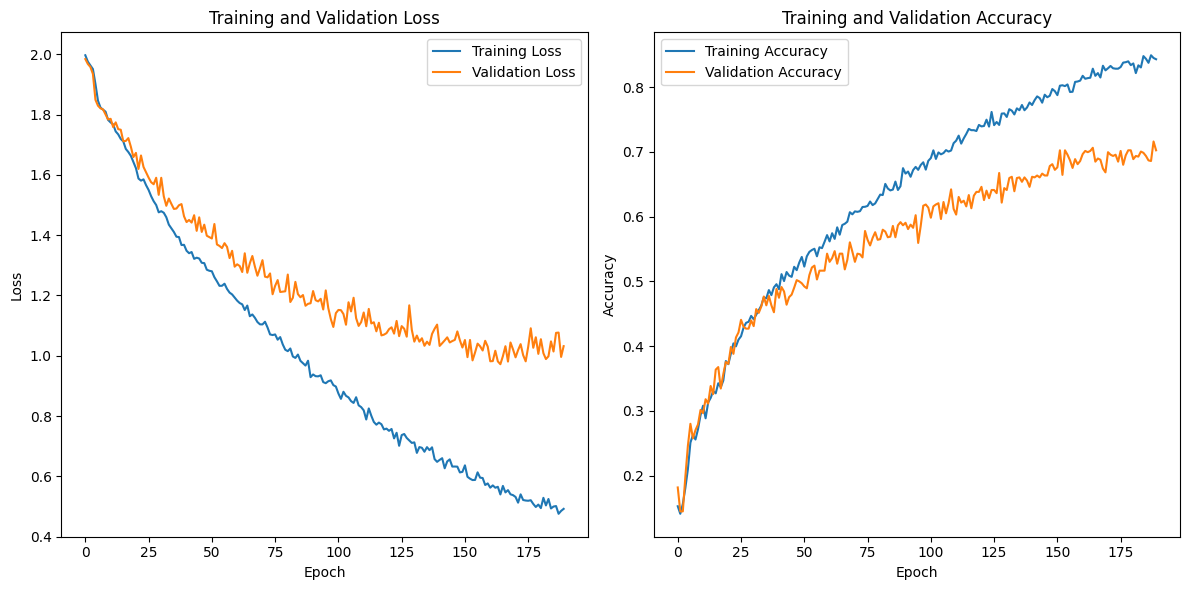

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()
